# View the 5D beam density in normalized slit-screen coordinates

$x_1$ = position of first vertical slit \
$x_2$ = position of second horizontal slit \
$y_1$ = position of horizontal slit \
$y_3$ = y position at view screen \
$x_3$ = x position at view screen

In [1]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from matplotlib import pyplot as plt
from matplotlib import colors
import plotly.graph_objs as go
from ipywidgets import interact
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils
from tools.utils import project

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Load data

In [3]:
folder = '_output'
filenames = os.listdir(folder)
for filename in filenames:
    if filename.startswith('coordinates3d_raw') or filename.startswith('f_raw'):
        print(filename)

coordinates3d_raw_220429190854-scan-xxpy-image-ypdE.npy
f_raw_220429190854-scan-xxpy-image-ypdE.mmp


In [4]:
filename = 'f_raw_220429190854-scan-xxpy-image-ypdE.mmp'
coordfilename = 'coordinates3d_raw_220429190854-scan-xxpy-image-ypdE.npy'

In [5]:
info = utils.load_pickle('_output/info.pkl')
info

{'acts': ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync'],
 'datadir': '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2022-04-29',
 'filename': '220429190854-scan-xxpy-image-ypdE',
 'variables': {'y1': {'pvname': 'ITSF_Diag:Slit_HZ34a',
   'center': 6.5,
   'distance': 14.5,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x2': {'pvname': 'ITSF_Diag:Slit_VT34b',
   'center': 15.0,
   'distance': 24.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x1': {'pvname': 'ITSF_Diag:Slit_VT34a',
   'center': 21.0,
   'distance': 17.5,
   'steps': 32,
   'min': -50.0,
   'max': 50.0}},
 'M': array([[1. , 0. , 0. ],
        [0. , 1. , 1.9],
        [0. , 0. , 1. ]]),
 'ndim': 3,
 'cam': 'cam34',
 'cam_zoom': 0.5,
 'cam_pix2mm_y': 0.4,
 'cam_pix2mm_x': 0.3968253968253968,
 'cam_shape': (512, 612),
 'image_crop_edges': {'x1': 200, 'x2': 450, 'y1': 135, 'y2': 435},
 'image_offset': 28.0,
 'image_thresh': 98.0,
 'image_downscale': 4,
 'image_shape': (75, 63),
 'rawgrid_shape': 

In [6]:
shape = info['rawgrid_shape']  # (x1, x2, y1, y3, x3)
dtype = info['im_dtype']
cam = info['cam']

In [7]:
f_raw = np.memmap(join(folder, filename), shape=shape, dtype=dtype, mode='r')
print(np.info(f_raw))

class:  memmap
shape:  (33, 33, 32, 75, 63)
strides:  (39916800, 1209600, 37800, 504, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7fabcfc46000
byteorder:  little
byteswap:  False
type: float64
None


Use the Right Hand Rule to determine the beam coordinates. [Insert image here]. (NEED TO FIX DIPOLE TRANSFER MATRIX FOR VS34; CURRENT CALCULATION IS WRONG AND IS CAUSING SIGN ERROR.
* Cam06 
    * x_slit (x1, x2) = x_beam
    * y_slit (y1) = -y_beam
    * y_screen (y3) = -y_beam
    * x_screen (x3) = -x_beam    
* Cam34
    * x_slit (x1, x2) = -x_beam (Are you sure??? Seems to give the wrong answer.)
    * y_slit (y1) = -y_beam
    * y_screen (y3) = -y_beam
    * x_screen (x3) = +x_beam

In [8]:
if cam.lower() == 'cam06':
    f_raw = f_raw[:, :, ::-1, ::-1, ::-1]
elif cam.lower() == 'cam34':
    # a5d = a5d[::-1, ::-1, ::-1, ::-1, :]
    f_raw = f_raw[:, :, ::-1, ::-1, :]

## Load slit coordinates

In [9]:
coords_3d = np.load(join(folder, coordfilename))  # [X1, X2, Y1]
coords_3d.shape

(3, 33, 33, 32)

In [10]:
dims = ["x1", "x2", "y1", "y3", "x3"]
dim_to_int = {dim: i for i, dim in enumerate(dims)}

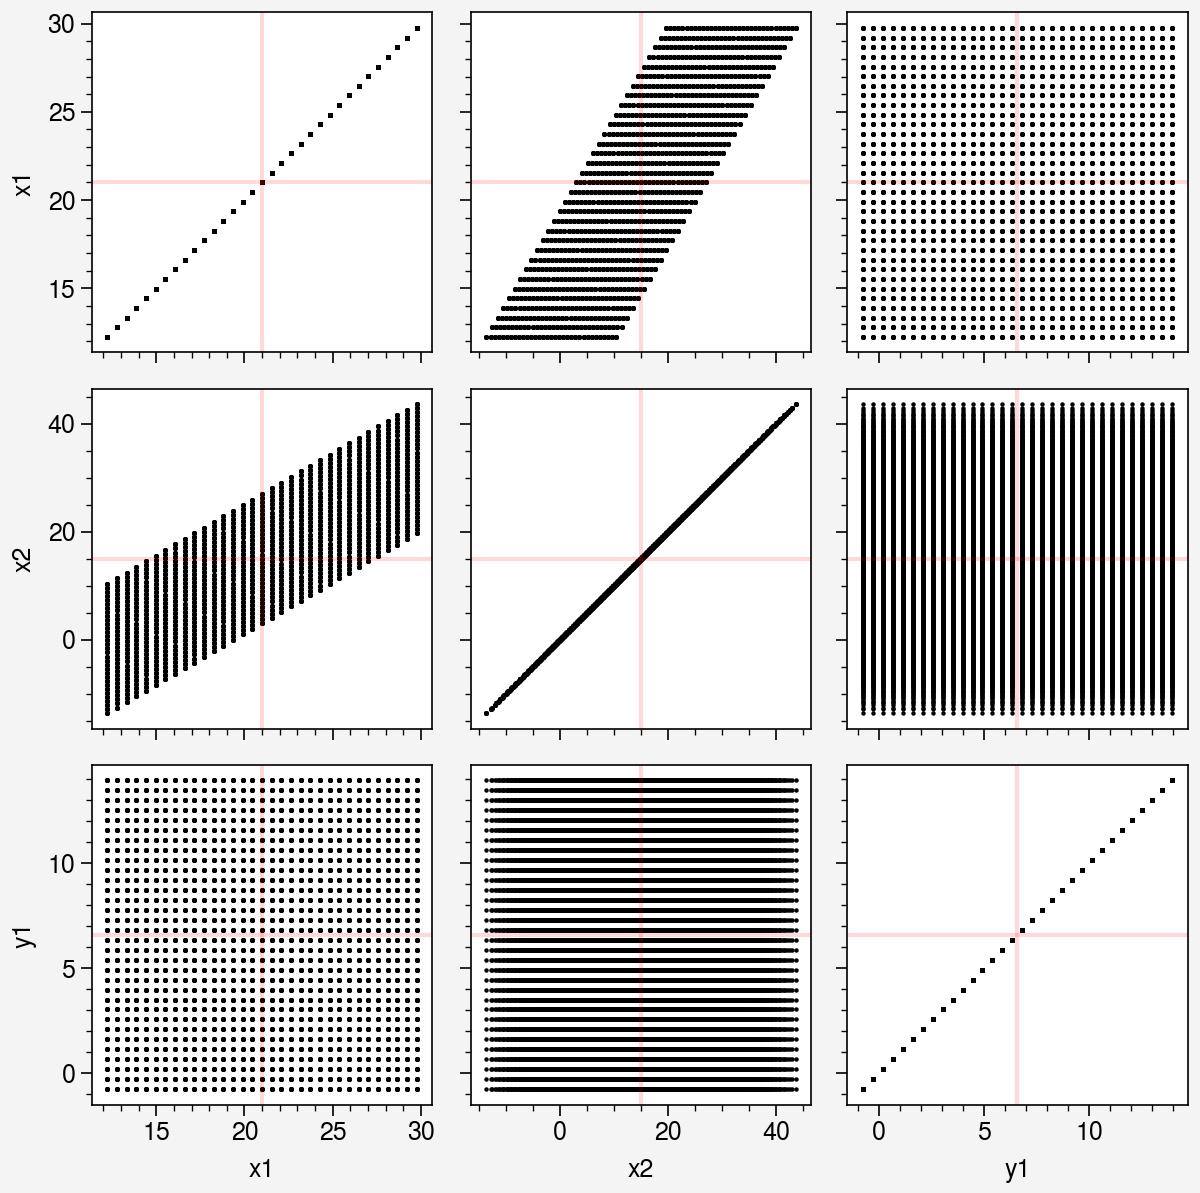

In [11]:
fig, axes = pplt.subplots(nrows=3, ncols=3, figwidth=6, spanx=False, spany=False)
for i in range(3):
    for j in range(3):
        U = coords_3d[j]
        V = coords_3d[i]
        ax = axes[i, j]
        ax.scatter(U.ravel(), V.ravel(), s=1, color='black')
        ax.axvline(np.mean(U), color='red', alpha=0.15)
        ax.axhline(np.mean(V), color='red', alpha=0.15)
    axes[i, 0].format(ylabel=dims[i])
    axes[-1, i].format(xlabel=dims[i])
plt.savefig('_output/grid3d.png')
plt.show()

Copy the grids into the five-dimensional space.

In [12]:
X1, X2, Y1 = coords_3d
X1 = utils.copy_into_new_dim(X1, shape[3:], axis=-1)
X2 = utils.copy_into_new_dim(X2, shape[3:], axis=-1)
Y1 = utils.copy_into_new_dim(Y1, shape[3:], axis=-1)

In [13]:
print('X1.shape =', X1.shape)
print('X2.shape =', X2.shape)
print('Y1.shape =', Y1.shape)

X1.shape = (33, 33, 32, 75, 63)
X2.shape = (33, 33, 32, 75, 63)
Y1.shape = (33, 33, 32, 75, 63)


In [14]:
Y3, X3 = np.meshgrid(np.arange(shape[3]), np.arange(shape[4]), indexing='ij')
Y3 = utils.copy_into_new_dim(Y3, shape[:3], axis=0)
X3 = utils.copy_into_new_dim(X3, shape[:3], axis=0)

In [15]:
print('Y3.shape =', Y3.shape)
print('X3.shape =', X3.shape)

Y3.shape = (33, 33, 32, 75, 63)
X3.shape = (33, 33, 32, 75, 63)


Make lists of centered coordinates `coords_`.

In [16]:
X1 = X1 - np.mean(X1)
X2 = X2 - np.mean(X2)
Y1 = Y1 - np.mean(Y1)
Y3 = Y3 - np.mean(Y3)
X3 = X3 - np.mean(X3)
coords_ = [X1, X2, Y1, Y3, X3]

In [17]:
for i, dim in enumerate(dims):
    print('dim =', dim)
    U = coords_[i]
    axes = [k for k in range(U.ndim) if k != i]
    idx = utils.make_slice(U.ndim, axes, ind=[0, 0, 0, 0])
    print(U[idx])
    print()

dim = x1
[-8.75876289e+00 -8.21134021e+00 -7.66391753e+00 -7.11649485e+00
 -6.56907216e+00 -6.02164948e+00 -5.47422680e+00 -4.92680412e+00
 -4.37938144e+00 -3.83195876e+00 -3.28453608e+00 -2.73711340e+00
 -2.18969072e+00 -1.64226804e+00 -1.09484536e+00 -5.47422680e-01
 -9.73443548e-13  5.47422680e-01  1.09484536e+00  1.64226804e+00
  2.18969072e+00  2.73711340e+00  3.28453608e+00  3.83195876e+00
  4.37938144e+00  4.92680412e+00  5.47422680e+00  6.02164948e+00
  6.56907216e+00  7.11649485e+00  7.66391753e+00  8.21134021e+00
  8.75876289e+00]

dim = x2
[-28.61809485 -27.86956701 -27.12103918 -26.37251134 -25.62398351
 -24.87545567 -24.12692784 -23.3784     -22.62987216 -21.88134433
 -21.13281649 -20.38428866 -19.63576082 -18.88723299 -18.13870515
 -17.39017732 -16.64164948 -15.89312165 -15.14459381 -14.39606598
 -13.64753814 -12.89901031 -12.15048247 -11.40195464 -10.6534268
  -9.90489897  -9.15637113  -8.4078433   -7.65931546  -6.91078763
  -6.16225979  -5.41373196  -4.66520412]

dim = 

## View 5D array in normalized slit-screen coordinates

Correlation between planes are removed... need to be careful interpreting these plots.

In [18]:
f_raw_min = np.min(f_raw)
f_raw_max = np.max(f_raw)
if f_raw_min < 0:
    print(f'min(f_raw) = {f_raw_min}. Clipping to 0.')
    f_raw = np.clip(f_raw, 0, None)
f_raw = f_raw / f_raw_max

### Interactive 

In [19]:
mplt.interactive_proj2d(f_raw / f_raw_max, dims=['x1', 'x2', 'y1', 'y3', 'x3'], 
                        slider_type='int', default_ind=(4, 3))

interactive(children=(Dropdown(description='cmap', options=('viridis', 'dusk_r', 'mono_r', 'plasma'), value='v…

In [20]:
mplt.interactive_proj2d(f_raw / f_raw_max, dims=['x1', 'x2', 'y1', 'y3', 'x3'], 
                        slider_type='range', default_ind=(4, 3))

interactive(children=(Dropdown(description='cmap', options=('viridis', 'dusk_r', 'mono_r', 'plasma'), value='v…

### Projections 

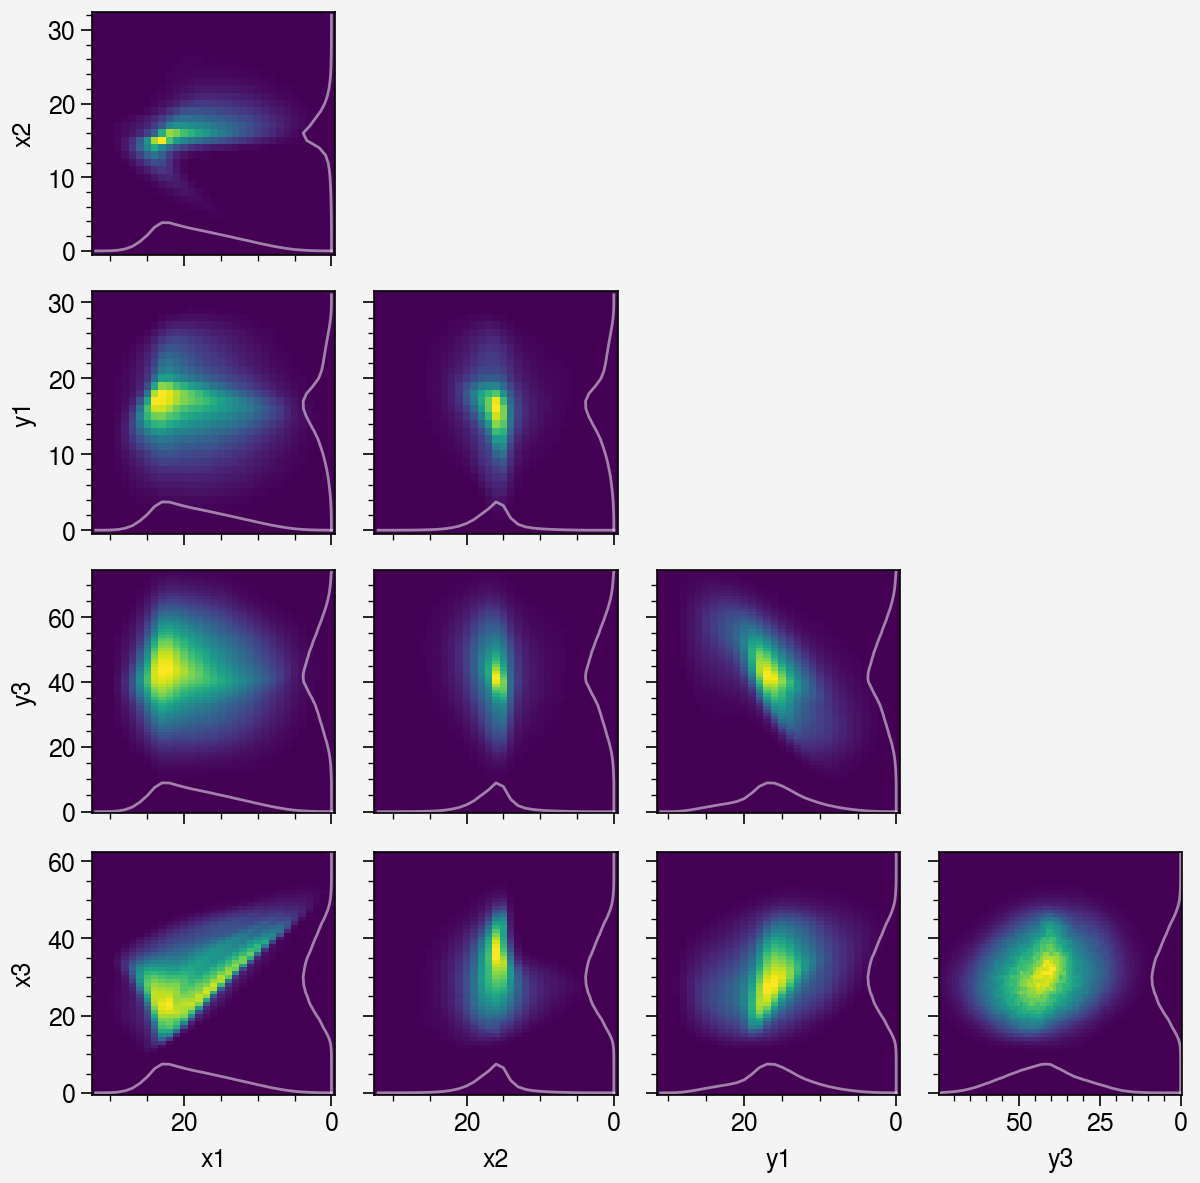

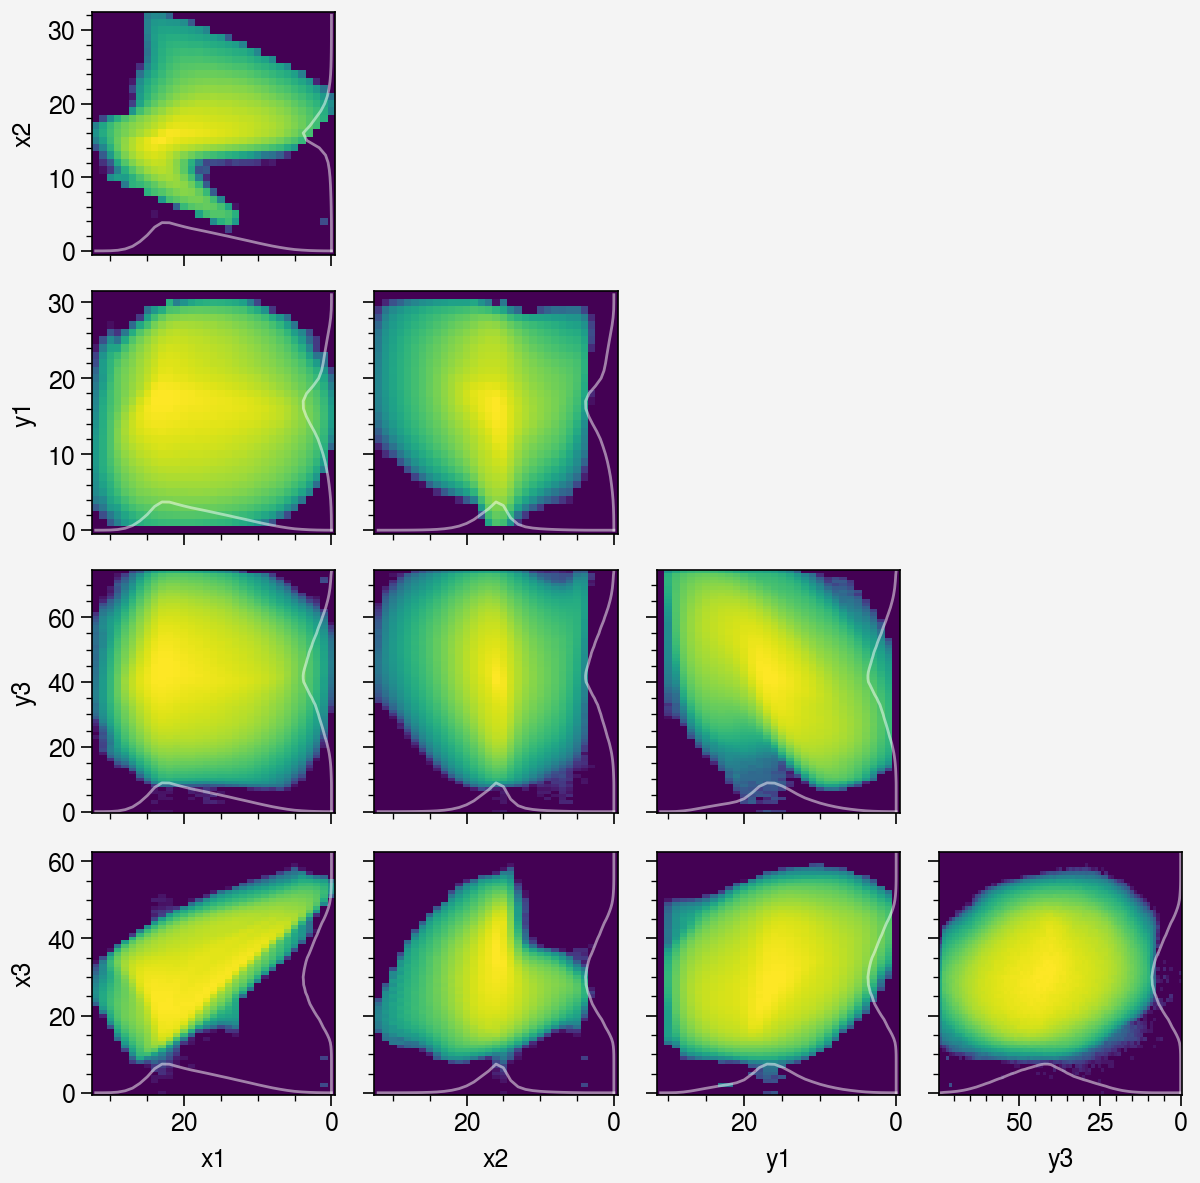

In [24]:
for norm in [None, 'log']:
    axes = mplt.corner(
        f_raw,
        labels=dims,
        norm=norm,
        diag_kind='None',
        fig_kws=dict(),
        prof=True,
        prof_kws=dict(lw=1.0, alpha=0.5, scale=0.12),
        handle_log='floor',
    )
    plt.savefig(f"_output/slitscreen_corner_log{norm=='log'}.png")
    plt.show()

### Slices

Compute the indices of the maximum pixel in the 5D array.

In [25]:
ind_max = np.unravel_index(np.argmax(f_raw), f_raw.shape)
print(ind_max)

(22, 17, 18, 46, 17)


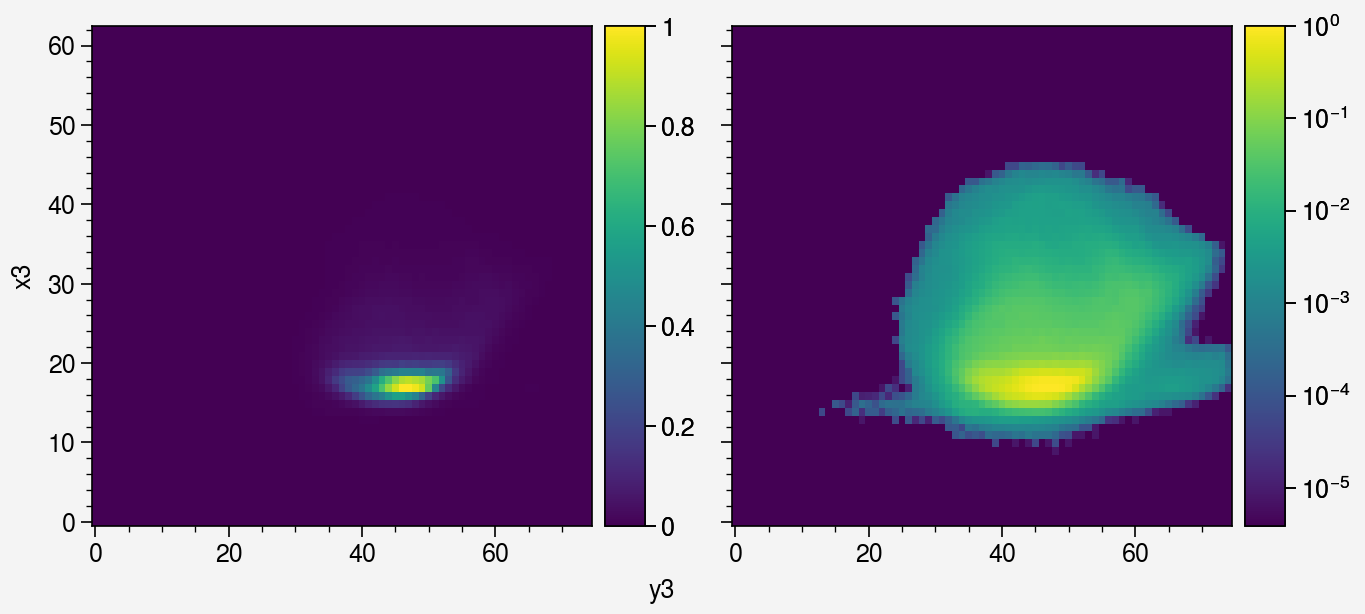

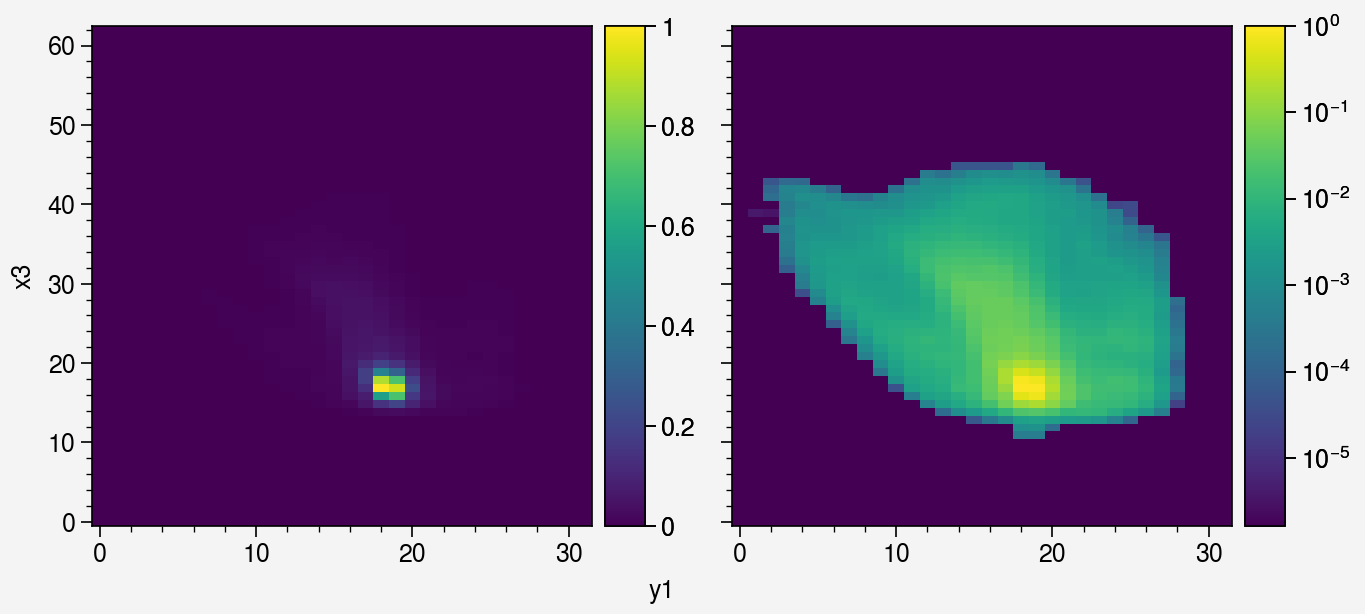

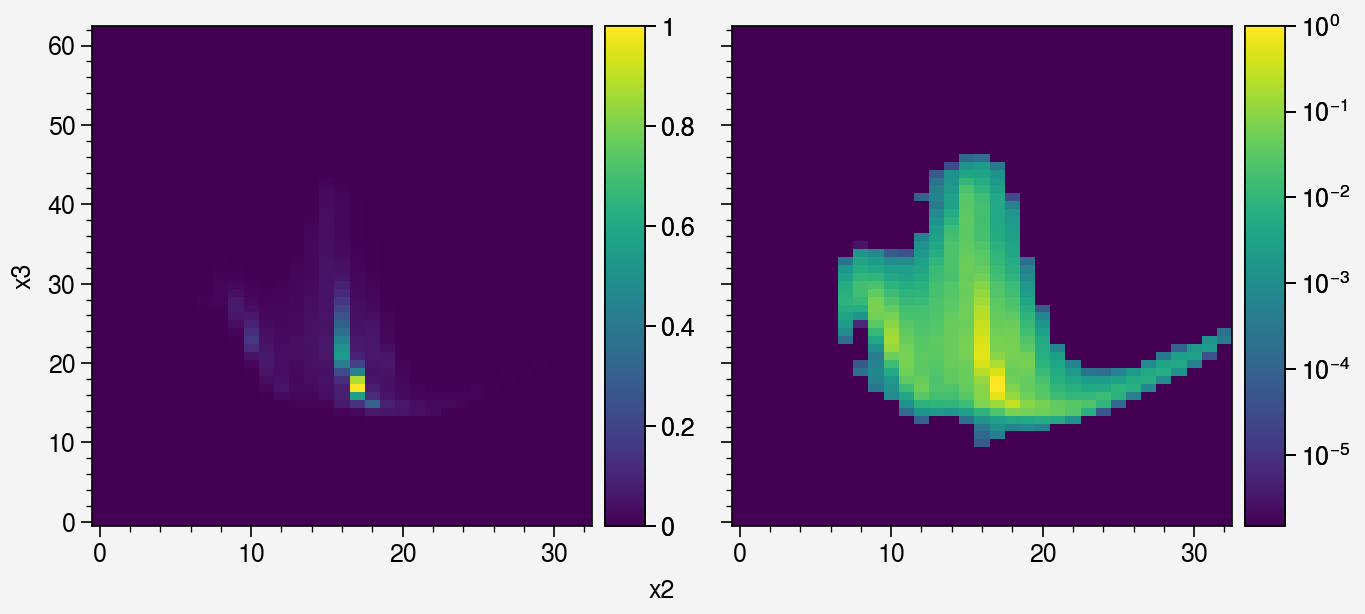

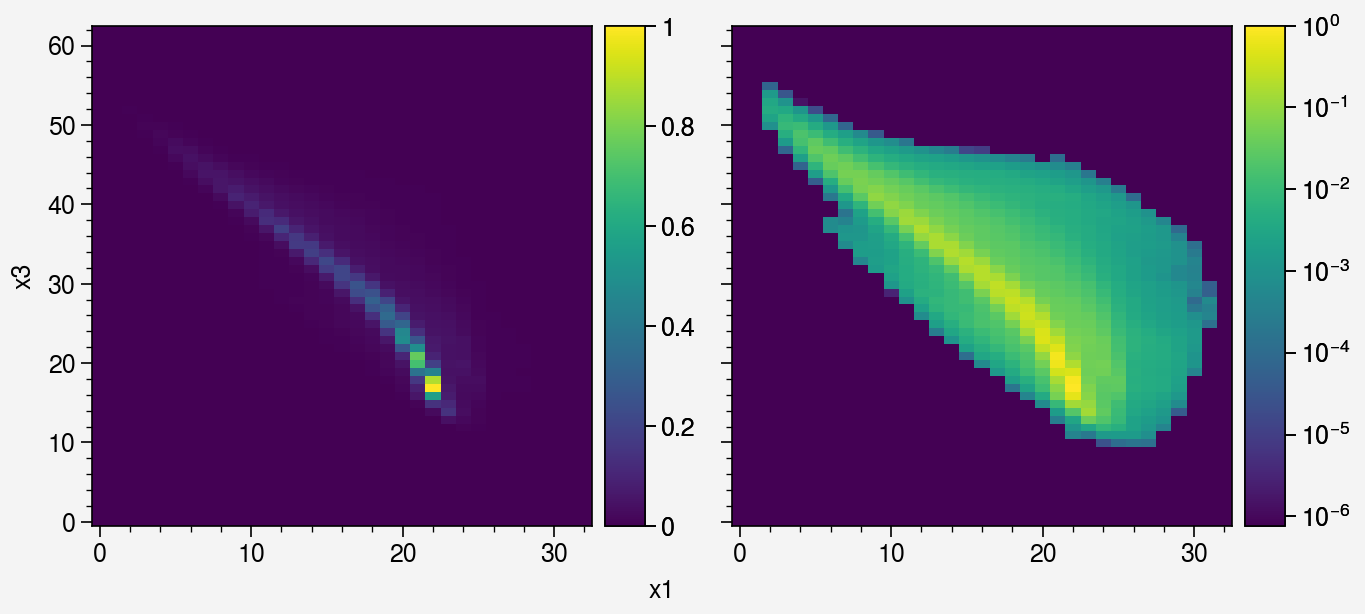

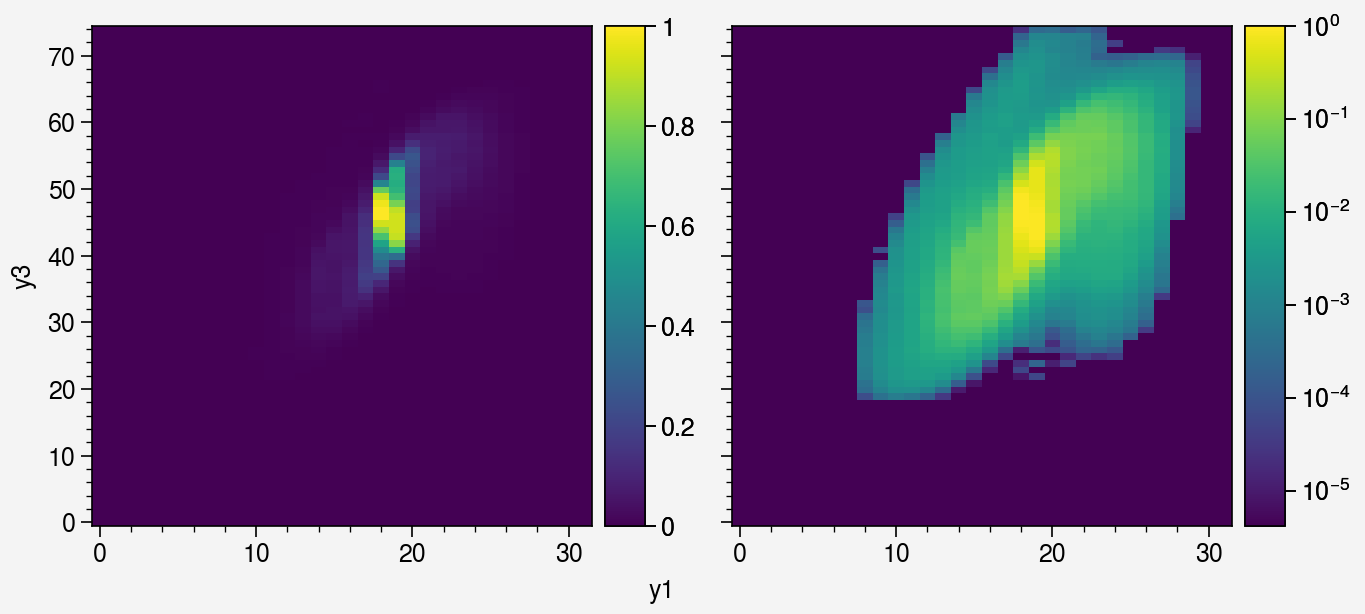

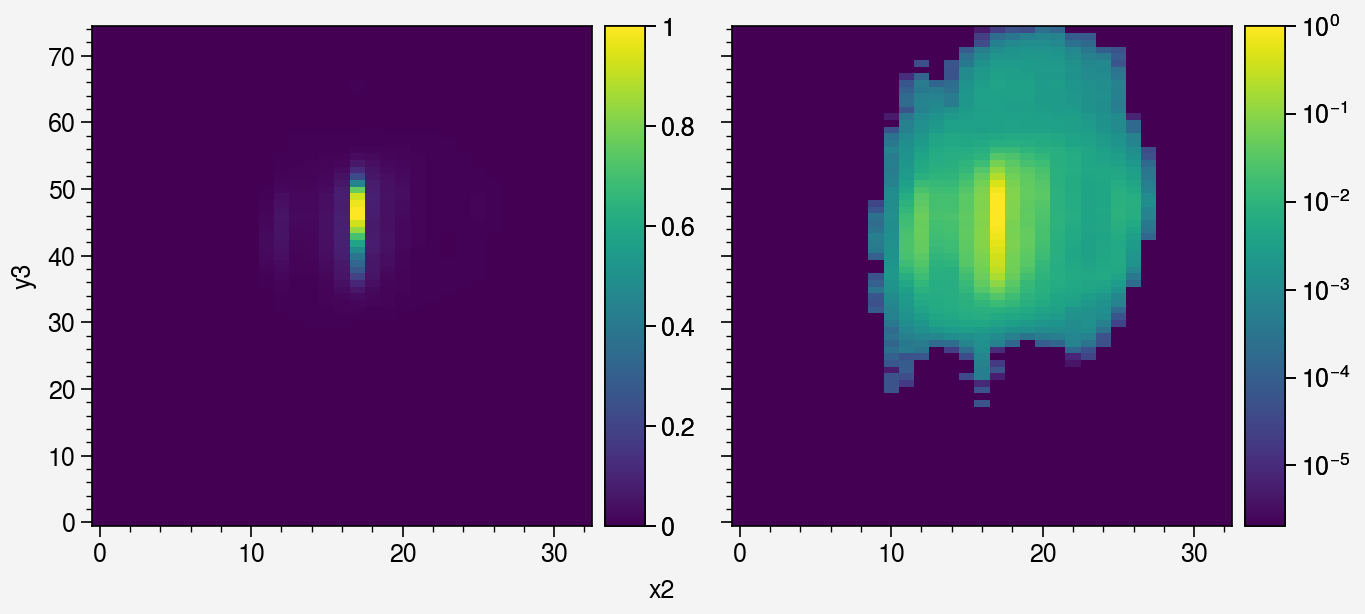

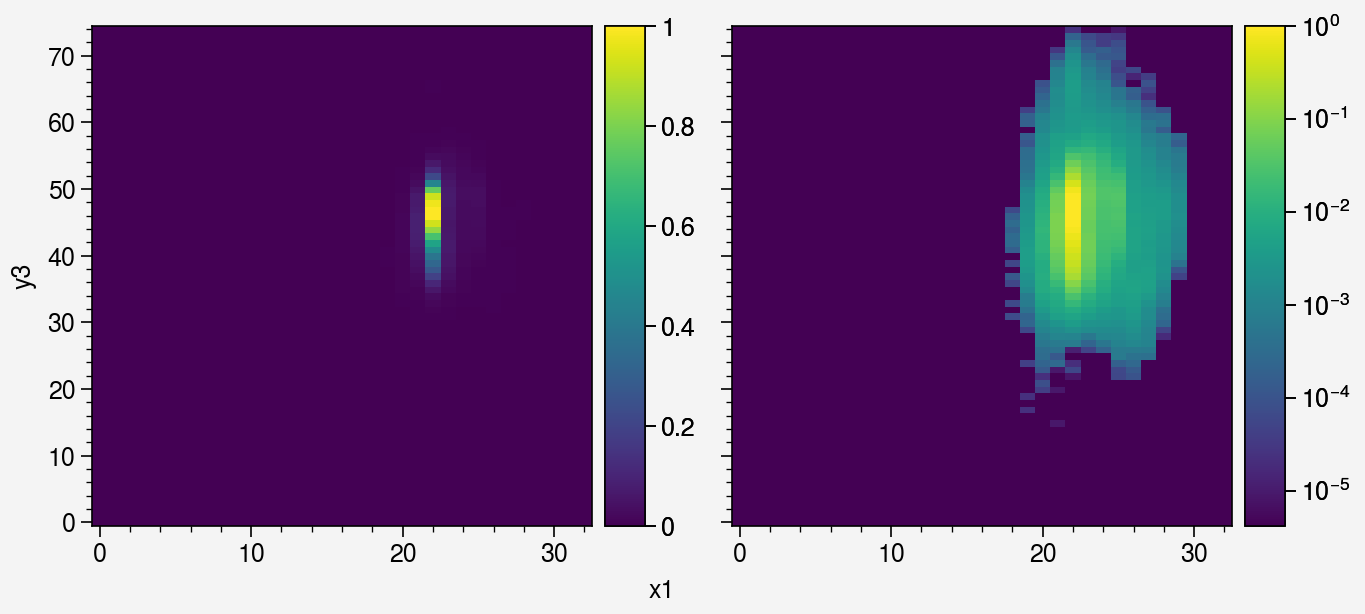

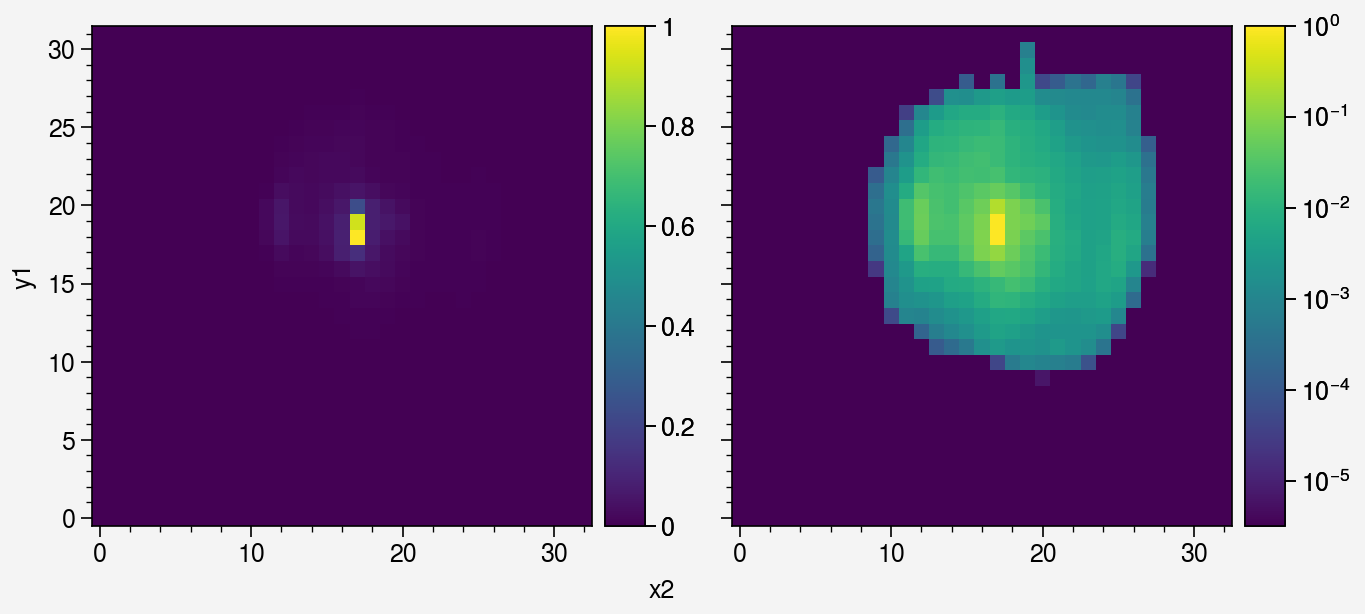

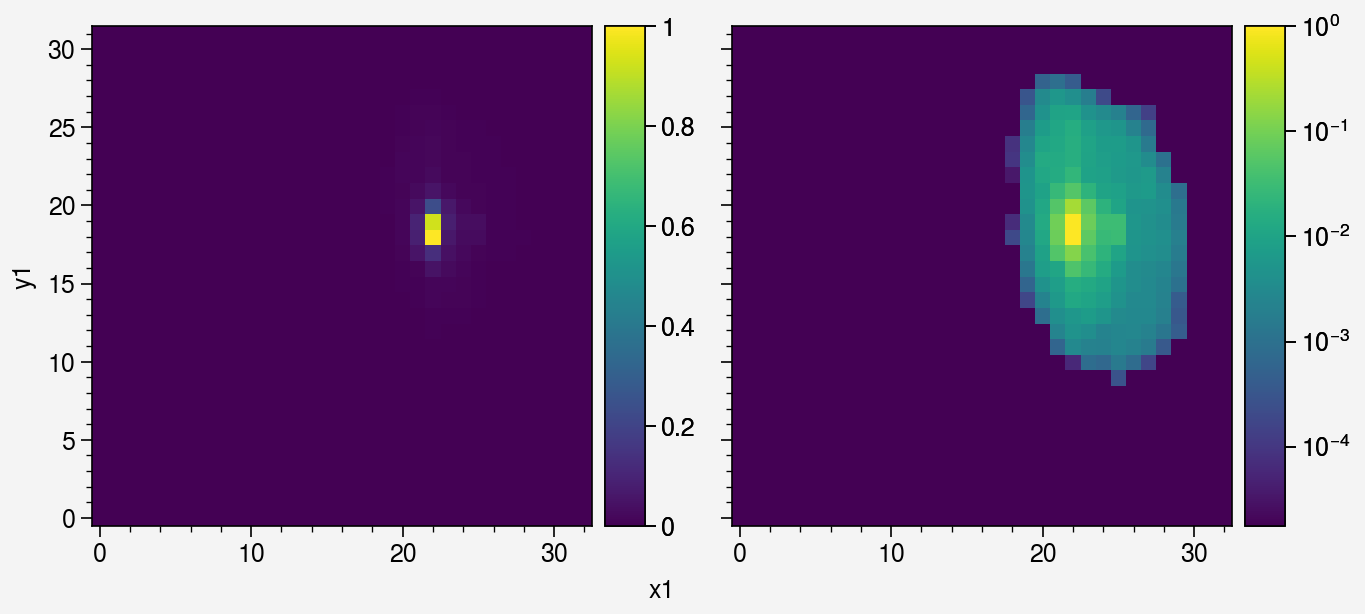

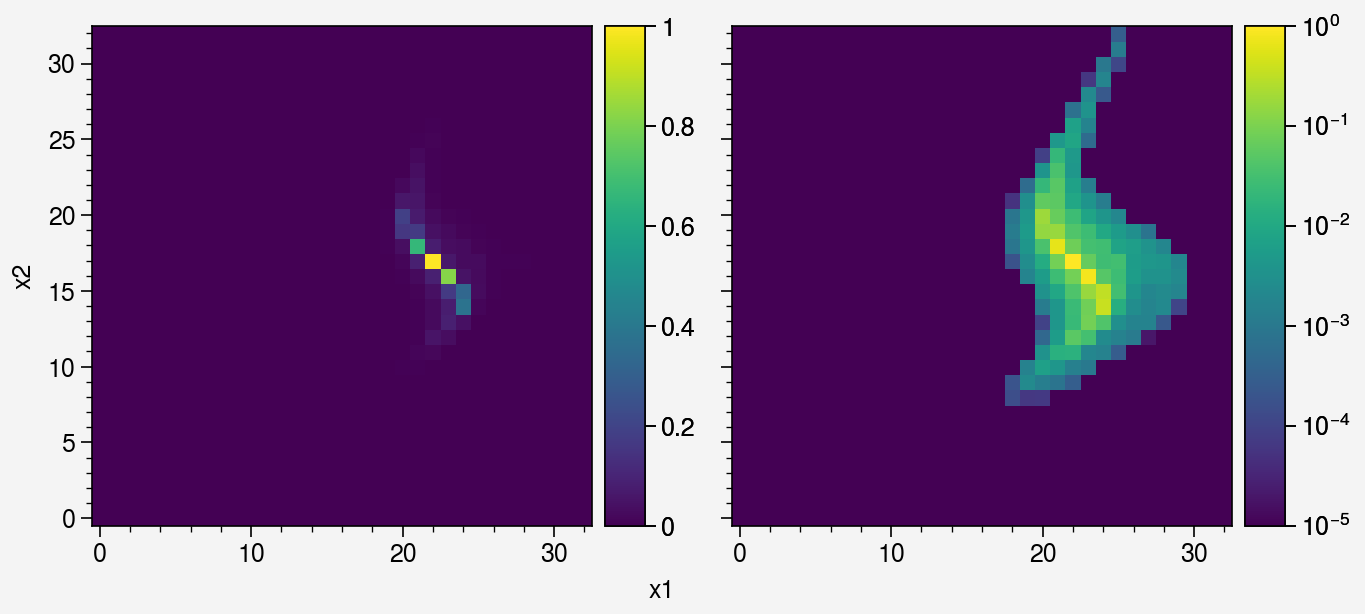

In [26]:
axes_slice = [(k, j, i) for i in range(f_raw.ndim) for j in range(i) for k in range(j)]
axes_view = [tuple([i for i in range(f_raw.ndim) if i not in axis])
             for axis in axes_slice]
for axis, axis_view in zip(axes_slice, axes_view):
    idx = utils.make_slice(5, axis, [ind_max[i] for i in axis])
    f_raw_slice = f_raw[idx]
    f_raw_slice = f_raw_slice / np.max(f_raw_slice)

    dim1, dim2 = [dims[i] for i in axis_view]
    
    fig, plot_axes = pplt.subplots(ncols=2)
    for ax, norm in zip(plot_axes, [None, 'log']):
        mplt.plot_image(f_raw_slice, ax=ax, norm=norm, colorbar=True, handle_log='floor')
    plot_axes.format(xlabel=dim1, ylabel=dim2)
    string = '_output/slitscreen_slice_'
    for i in axis:
        string += f'_{dims[i]}-{ind_max[i]}'
    plt.savefig(string + '.png')
    plt.show()

In [27]:
utils.save_pickle('_output/info.pkl', info)
file = open('_output/info.txt', 'w')
for key, value in info.items():
    file.write(f'{key}: {value}\n')
file.close()